In [2]:
%matplotlib inline

In [77]:
import os  # for listdir
import sys  # for getsizeof

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

In [15]:
import rosbag

## Exploring available data

2019-sylvan had dORP hits on dives 552 and 553

In [8]:
dive = 552
cruise = "2019-sylvan"
datadir = "/media/psf/coex_data/{}/dives/sentry{}/nav-sci/raw/rosbag".format(cruise, dive)

In [9]:
# These are the bagfiles with headers but no messages (size is 8k, so can't just check for 0 byte files)
empty_files = [
    # 2019-sylvan/sentry552
    "sensors_2019-12-21-00-56-40_0.bag",  # decktest
    "sensors_2019-12-21-00-10-33_11.bag", 
    "sensors_2019-12-21-01-19-46_0.bag",  # on deck, sensors not started
    "sensors_2019-12-21-02-19-47_1.bag",  # on deck, sensors not started
    "sensors_2019-12-21-12-57-12_0.bag",  # post dive something?
    "sensors_2019-12-21-13-57-13_1.bag",  
]    

In [85]:
bagfiles = [ff for ff in os.listdir(datadir) if ff.startswith("sensors") and "active" not in ff and ff not in empty_files]

In [86]:
bagfiles

['sensors_2019-12-21-03-19-47_2.bag',
 'sensors_2019-12-21-04-19-46_3.bag',
 'sensors_2019-12-21-05-19-47_4.bag',
 'sensors_2019-12-21-06-19-47_5.bag',
 'sensors_2019-12-21-07-19-47_6.bag',
 'sensors_2019-12-21-08-19-47_7.bag',
 'sensors_2019-12-21-09-19-47_8.bag',
 'sensors_2019-12-21-10-19-47_9.bag',
 'sensors_2019-12-21-11-19-47_10.bag',
 'sensors_2019-12-21-12-19-47_11.bag']

In [168]:
def load_data(cruise, dive):
    # type(String, int) -> np.array, np.array, np.array
    """
    Load all non-blacklisted bagfiles from input cruise and dive.
    Return Nx2 np.array for depth, obs and orp data. First column is timestamp, 2nd is the data.
    
    Inputs:
    * cruise: e.g. "2019-sylvan"
    * dive: e.g. 522
    Outputs:
    * depth: N x 2 np.array of depth (in m) from the Paro. 1st col is time since epoch (secs) 
    * obs: N x 2 np.array giving raw obs data (raw[0])
    * orp: N x 2 np.array giving raw orp data (raw[0])
    """
    datadir = "/media/psf/coex_data/{}/dives/sentry{}/nav-sci/raw/rosbag".format(cruise, dive)
    bagfiles = [ff for ff in os.listdir(datadir)
                if ff.startswith("sensors") and "active" not in ff and ff not in empty_files]
    bagfiles.sort()  # Make sure they're in chronological order
    print(bagfiles)

    # we want the data as numpy arrays, where the first column is time and the 2nd column is sensor data
    depth = None
    obs = None
    orp = None

    # Hmmm. at 100, we still see some pretty fast changes.
    # However, they're in the wrong direction to be detected, and there's few enough of them
    # that I'm not worried about them meaningfully messing with the stddev calculations.
    # Maybe make this a parameter.
    below_surface = False
    depth_threshold = 100  # don't start analyzing orp/obs data until below the surface

    for bagfile in bagfiles:
        bagpath = "{}/{}".format(datadir, bagfile)
        depth_count = 0  # Counts the number of messages where depth > threshold

        with rosbag.Bag(bagpath, 'r') as bag:
            for topic, msg, tt in bag.read_messages():
                if "/sentry/sensors/paro/depth" == topic:
                    val = msg.depth
                    # Check whether we're submerged, which is needed for other sensors
                    if val > depth_threshold:
                        depth_count += 1
                        if depth_count > 5:
                            below_surface = True
                    else:
                        if below_surface:
                            print("WARNING: had been below surface, but aren't anymore!")
                        below_surface = False
                        depth_count = 0
                    # Store the data
                    if depth is None:
                        depth = np.array([[msg.header.stamp.to_sec(), msg.depth]])
                    else:
                        depth = np.append(depth, [[msg.header.stamp.to_sec(), msg.depth]], axis=0)
                elif "/sentry/sensors/obs/a2d2" == topic:
                    if not below_surface:
                        continue
                    if obs is None:
                        obs = np.array([[msg.header.stamp.to_sec(), msg.raw[0]]])
                    else:
                        obs = np.append(obs, [[msg.header.stamp.to_sec(), msg.raw[0]]], axis=0)
                elif "/sentry/sensors/orp/a2d2" == topic:
                    if not below_surface:
                        continue
                    if orp is None:
                        orp = np.array([[msg.header.stamp.to_sec(), msg.raw[0]]])
                    else:
                        orp = np.append(orp, [[msg.header.stamp.to_sec(), msg.raw[0]]], axis=0)
                #if depth_count > 1000:
                #    break
            
        print("Done with {}".format(bagpath))
        if depth is None:
            print("No depth data!")
        else:
            print("depth.shape = {}".format(depth.shape))
    return depth, obs, orp
                

In [139]:
depth, obs, orp = load_data(cruise, dive)

['sensors_2019-12-21-03-19-47_2.bag', 'sensors_2019-12-21-04-19-46_3.bag', 'sensors_2019-12-21-05-19-47_4.bag', 'sensors_2019-12-21-06-19-47_5.bag', 'sensors_2019-12-21-07-19-47_6.bag', 'sensors_2019-12-21-08-19-47_7.bag', 'sensors_2019-12-21-09-19-47_8.bag', 'sensors_2019-12-21-10-19-47_9.bag', 'sensors_2019-12-21-11-19-47_10.bag', 'sensors_2019-12-21-12-19-47_11.bag']
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-03-19-47_2.bag
depth.shape = (20825, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-04-19-46_3.bag
depth.shape = (56674, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-05-19-47_4.bag
depth.shape = (92523, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-06-19-47_5.bag
depth.shape = (128373, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/

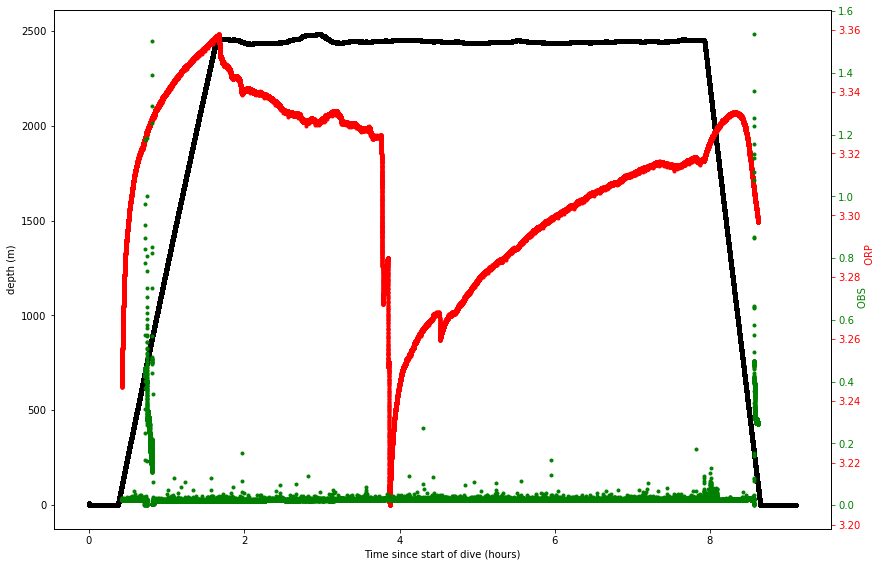

In [234]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
t0 = depth[0,0]
depth_hours = (depth[:,0]-t0) / (60.*60.)
ax.plot(depth_hours, depth[:,1], 'k.')
ax.set_ylabel("depth (m)")
ax.set_xlabel("Time since start of dive (hours)")

orp_ax = ax.twinx()
orp_hours = (orp[:,0]-t0) / (60.*60.)
orp_ax.plot(orp_hours, orp[:,1], 'r.')
orp_ax.set_ylabel("          ORP", color='r')

orp_ax.yaxis.label.set_color('red')
orp_ax.tick_params(axis='y', colors='red')

obs_ax = ax.twinx()
obs_hours = (obs[:,0]-t0) / (60.*60.)
obs_ax.plot(obs_hours, obs[:,1], 'g.')
obs_ax.set_ylabel("OBS                  ")

obs_ax.yaxis.label.set_color('green')
obs_ax.tick_params(axis='y', colors='green')

#ax.set_xlim(0.25, 0.5)


In [257]:
def calc_dorp_dt(orp):
    """
    Calculate dorp/dt, following implementation in dsros_process_orp.m:
        [orpfilt_b, orpfilt_a] = butter(3, 0.1);
        orp.dorpdt = filtfilt(orpfilt_b, orpfilt_a, [0; diff(orp.v)'./diff(orp.hdr_t')])';
        
    This function takes 5ms to run on a full dive's data, so there's no reason to 
    try to run it sequentially / on a windowed set of data.

    [b,a] = butter(n,Wn) 
        -> https://www.mathworks.com/help/signal/ref/butter.html
        -> n'th order butterworth filter
        -> Wn is with normalized cutoff frequency, in pi rad / sample.
        -> Based on matlab examples, Wn = (cutoff_freq) / (sampling_freq / 2)
        -> Our sampling rate is 5.843 Hz, which corresponds to cutoff freq of ~0.292 Hz for Wn = 0.1 (from code)
    b, a = scipy.signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
        -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
        -> use `output='ba='` to match matlab call.
           However, the docs suggest using sos to avoid numerical errors in applying the filter.
        -> Wn is in half-cycles/sample (so, same units as matlab, so long as we don't pass in fs)
        -> matlab's defaults to a digital filter, so keep analog=False
        
    Y = diff(X)
        -> https://www.mathworks.com/help/matlab/ref/diff.html
        -> Calculates differences between adjacent elements of X
    da = numpy.diff(a, n=1, axis=-1, prepend=<no value>, append=<no value>)
    y = numpy.divide(x1, x2)
        -> https://numpy.org/doc/stable/reference/generated/numpy.divide.html
        
    y = filtfilt(b,a,x)
        -> https://www.mathworks.com/help/signal/ref/filtfilt.html
        -> processes in forward and reverse directions
    y = scipy.signal.filtfilt(b, a, x, axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)
        -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
        -> also says to prefer sosfiltfilt in most cases
    """
    
    # NB: We need to be careful to NEVER raise a floating point error in any of the
    #     math that runs on Sentry. However, we do want to log it. It looks like
    #     one option is to use `np.seterr` s.t. 1/0 = 0, but I'm not sure if you can
    #     then catch it and report it via roslog?
    #     We DEFINITELY want numpy to handle it s.t. one bad value just leads to a 
    #     neighborhood of invalid, rather than no data for the whole dive.
    
    print("Input shape: {}".format(orp.shape))
    
    dorp = np.diff(orp, axis=0)
    print("dorp shape: {}".format(dorp.shape))
    
    dorpdt = np.divide(dorp[:,1], dorp[:,0])
    print("dorpdt shape: {}".format(dorpdt.shape))
    # Prepend 0 to keep dorpdt the same shape as the timestamps. 
    dorpdt = np.insert(dorpdt, 0, 0, axis=0)
    
    b, a = scipy.signal.butter(3, 0.1)
    print("Filter coefficients: {}, {}".format(b, a))
    dorpdt_filtered = scipy.signal.filtfilt(b, a, dorpdt)  # NB, the matlab code prepends a 0 here so it'll be the same dimension as time.
    print("filtered dorpdt shape: {}".format(dorpdt_filtered.shape))
    
    # Output also needs to carry along the timestamps
    out = np.zeros(orp.shape)
    out[:,0] = orp[:,0]
    out[:,1] = dorpdt_filtered
    
    return out

In [258]:
dorpdt = calc_dorp_dt(orp)

Input shape: (172526, 2)
dorp shape: (172525, 2)
dorpdt shape: (172525,)
Filter coefficients: [0.00289819 0.00869458 0.00869458 0.00289819], [ 1.         -2.37409474  1.92935567 -0.53207537]
filtered dorpdt shape: (172526,)


In [251]:
# Find isolated peaks, so we don't have to publish so many! 
# Then, only mark times that are both local maxima and above the threshold

In [286]:
def find_peaks(dorp, threshold_factor):
    """
    Finds the time and value of unique dORP peaks, requiring their magnitude
    to be threshold_factor * stddev.
    
    Returned data will be Nx2 np.array, with first column time and 2nd column dorp/dt.
    The array will be sorted to have the most negative dorp/dt first.
    """
    peak_idxs = []
    npts, _ = dorp.shape
    stddev = np.std(dorp[:,1])
    for idx in np.arange(1, npts-1):
        is_extrema = (dorp[idx,1] < dorp[idx-1, 1] and dorp[idx,1] < dorp[idx+1, 1])
        is_hit = dorp[idx,1] < -threshold_factor * stddev 
        if is_extrema and is_hit:
            peak_idxs.append(idx)
    peaks = dorp[peak_idxs,:]
    # Sort in order of dorp/dt, to make it easier to send the N largest.
    peaks = peaks[peaks[:,1].argsort()]
    
    return peaks

In [289]:
peaks = find_peaks(dorpdt, 5)

1576913450.5690525


(1576913400.5690525, 1576913850.5690525)

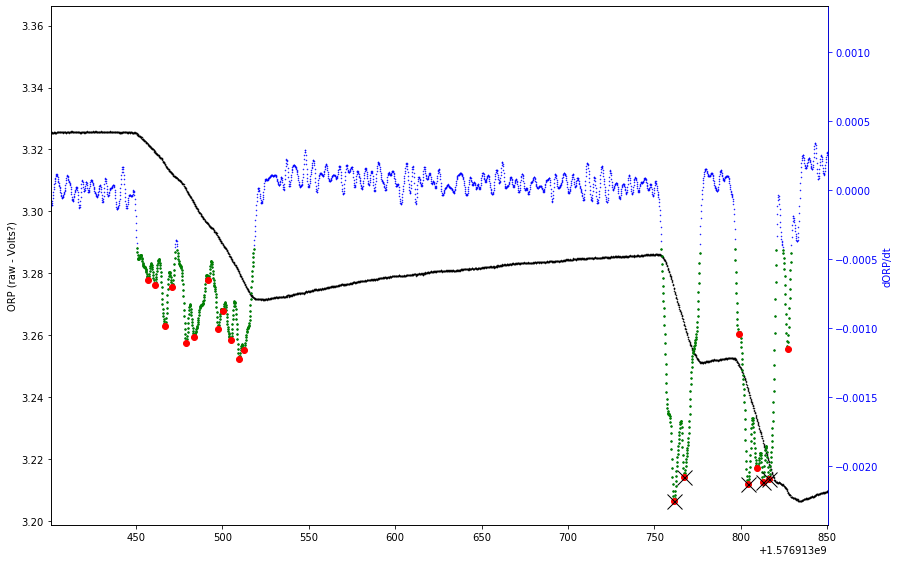

In [288]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])
ax.plot(orp[:,0], orp[:,1], 'k.', ms=1)
ax.set_ylabel('ORP (raw - Volts?)')

ax2 = ax.twinx()
ax2.plot(dorpdt[:, 0], dorpdt[:,1], 'b.', ms=1)

# Plot thresholded detections based on criteria in matlab scripts
idxs, = np.where(dorpdt[:,1] < -4*np.std(dorpdt[:,1]))
ax2.plot(dorpdt[idxs, 0], dorpdt[idxs,1], 'g.', ms=3)
# Plot all local minima that are also below the threshold.
ax2.plot(peaks[:,0], peaks[:,1], 'ro')
# Finally, plot the top N peaks.
ax2.plot(peaks[0:5,0], peaks[0:5,1], 'kx', ms=15)

ax2.set_ylabel("dORP/dt", color='b')
ax2.spines['right'].set_color('blue')
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')

tc = dorpdt[idxs[0],0]
print(tc)
ax.set_xlim(tc-50, tc+400)

65536

# Looking at every dive we have ...
First, do this with post-processing, just to load them in. Create subplots for every range of values with a peak.

My main questions are:
* How to cluster detections into peaks in a way that is robust across all data and leads to few-enough peaks that we'll get all relevant data? Is simply finding local minima enough, or do we need to combine neighboring minima?
* Does it even make sense to require a threshold, vs. simply transmitting the N largest peaks?
* What data and at what subsampling we need to transmit the "detailed" data at.

# Simulating what peaks would be published
Every 15 or 30 simulated minutes, show a subplot of what the current peaks would be.

# (Answered) Questions!

### What's going on with raw/proc??

I'm using raw[0] for both (it's the only field filled in)

However, in orp data, proc[] is raw[] - 5; in obs proc[] is raw[] + 5.0. 

### Do we need to worry about the descent/ascent data affecting stddev?
They are definite outliers, but in the wrong direction, so they'd only affect the statistics, not the detections.

I tried cutting it out, then calculating stddev, and there are so many samples that it just doesn't matter (aside from at the very start)

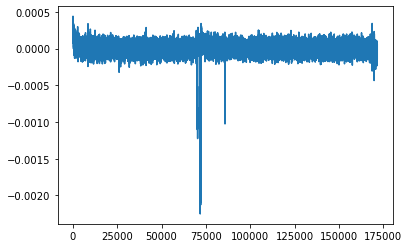

In [246]:
plt.plot(dorpdt[400:172000])

In [210]:
np.std(dorpdt), np.std(dorpdt[10000:160000])

(0.00010487016669506395, 0.00010641541908030756)

### Do we need to worry about keeping the scalar data in memory?

In [83]:
# A ~10 hr dive's depth data is only 5 MB!
depth.shape, sys.getsizeof(depth)/(1024.*1024.)

((337182, 2), 5.1450958251953125)

### Q: Do we need to worry about only calculting dORP/dt for segments of the data?

In [216]:
# And, it looks like running calc dorp takes < 10 ms, so no reason to not run it once a minute 
# (There's no reason to calculate dORP/dt more frequently than that, since it can't be sent topside more more often.)
import timeit
timeit.timeit("calc_dorp_dt(orp)", setup="from __main__ import calc_dorp_dt, orp", number=1)

Input shape: (172526, 2)
dorp shape: (172525, 2)
dorpdt shape: (172525,)
Filter coefficients: [0.00289819 0.00869458 0.00869458 0.00289819], [ 1.         -2.37409474  1.92935567 -0.53207537]
filtered dorpdt shape: (172526,)


0.008581724017858505

### Q: What is an appropriate value of Wn? (or ... what does the one in the matlab code mean?)

mean = 0.17113328283491283, median = 0.17089200019836426
Sampling rate = 5.843398685717203 Hz
For Wn = 0.1, cutoff_freq = 0.29216993428586013


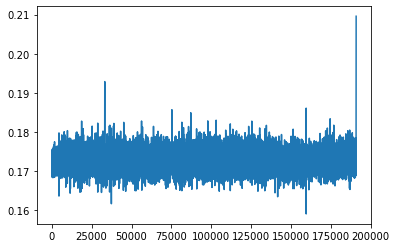

In [111]:
# Checking frequency of orp data
# Depth data comes at 10 Hz
# ORP & OBS dt is 0.171 for mean of 5.843 Hz.
dt = obs[1:,0] - obs[:-1,0]
plt.plot(dt)
print("mean = {}, median = {}".format(np.mean(dt), np.median(dt)))
sampling_freq = 1.0 / np.mean(dt)
print("Sampling rate = {} Hz".format(sampling_freq))
Wn = 0.1  # From existing code.
cutoff = Wn * (sampling_freq / 2)
print("For Wn = 0.1, cutoff_freq = {}".format(cutoff))

### Q: Is reshaping the array with every new piece of data prohibitively slow?

In [101]:
# From looking at this, it seems like the rosbag operations are actually the slow bit, 
# so I should wait before trying to optimize away the array appends.
import cProfile
cProfile.run("load_data('2019-sylvan', 552)")

['sensors_2019-12-21-03-19-47_2.bag', 'sensors_2019-12-21-04-19-46_3.bag', 'sensors_2019-12-21-05-19-47_4.bag', 'sensors_2019-12-21-06-19-47_5.bag', 'sensors_2019-12-21-07-19-47_6.bag', 'sensors_2019-12-21-08-19-47_7.bag', 'sensors_2019-12-21-09-19-47_8.bag', 'sensors_2019-12-21-10-19-47_9.bag', 'sensors_2019-12-21-11-19-47_10.bag', 'sensors_2019-12-21-12-19-47_11.bag']
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-03-19-47_2.bag
depth.shape = (1001, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-04-19-46_3.bag
depth.shape = (2002, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-05-19-47_4.bag
depth.shape = (3003, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/sensors_2019-12-21-06-19-47_5.bag
depth.shape = (4004, 2)
Done with /media/psf/coex_data/2019-sylvan/dives/sentry552/nav-sci/raw/rosbag/senso